In [2]:
!pip install nemreader

In [59]:
import numpy as np
import pandas as pd
import os
from nemreader import read_nem_file
import datetime
from matplotlib import pyplot
pd.set_option('display.max_rows', 10)

['NEM12Sample.zip']

In [60]:
m = read_nem_file('NEM12Sample.zip')
#channels = [chan for chan in chan_dict for chan_dict in m.transactions.values()]
suffix = 'E1'
readings_list = []
#for suffix in channels:
for nmi in m.readings:
    for channel in m.readings[nmi]:
        for reading in m.readings[nmi][suffix]:
            readings_list.append(reading)
readings_df = pd.DataFrame(readings_list)
readings_df['t_start'] = readings_df['t_start'].apply(lambda x : x + datetime.timedelta(days=(365.25*14)-5.5))
readings_df['t_end'] = readings_df['t_end'].apply(lambda x : x + datetime.timedelta(days=(365.25*14)-5.5))
readings_df['Date'] = readings_df['t_start'].apply(lambda x : x.date())
readings_df

,t_start,t_end,read_value,uom,meter_serial_number,quality_method,event_code,event_desc,read_start,read_end,Date
0,2019-03-10 00:00:00,2019-03-10 00:30:00,300.00,KWH,01002,A,,,None,None,2019-03-10
1,2019-03-10 00:30:00,2019-03-10 01:00:00,266.10,KWH,01002,A,,,None,None,2019-03-10
2,2019-03-10 01:00:00,2019-03-10 01:30:00,191.55,KWH,01002,A,,,None,None,2019-03-10
3,2019-03-10 01:30:00,2019-03-10 02:00:00,247.80,KWH,01002,A,,,None,None,2019-03-10
4,2019-03-10 02:00:00,2019-03-10 02:30:00,288.60,KWH,01002,A,,,None,None,2019-03-10
...,...,...,...,...,...,...,...,...,...,...,...
379,2019-03-13 21:30:00,2019-03-13 22:00:00,135.75,KWH,01002,A,,,None,None,2019-03-13
380,2019-03-13 22:00:00,2019-03-13 22:30:00,135.75,KWH,01002,A,,,None,None,2019-03-13
381,2019-03-13 22:30:00,2019-03-13 23:00:00,136.65,KWH,01002,A,,,None,None,2019-03-13
382,2019-03-13 23:00:00,2019-03-13 23:30:00,136.05,KWH,01002,A,,,None,None,2019-03-13


In [7]:
hourly_df = readings_df.resample(on='t_start',rule=datetime.timedelta(hours=1))
myfunc = lambda x : sum(x)/2
aggfuncs = dict.fromkeys(readings_df.columns,max)
aggfuncs.update({'read_value' : myfunc, 't_start' : min})
hourly_df = hourly_df.agg(aggfuncs).reset_index(drop=True)
hourly_df['hour'] = hourly_df['t_start'].apply(lambda x : x.hour)
hourly_df['weekday'] = hourly_df['t_start'].apply(lambda x : x.weekday()) # 0 = Monday, 6 = Sunday
hourly_df

,t_start,t_end,read_value,uom,meter_serial_number,quality_method,event_code,event_desc,read_start,read_end,Date,hour,weekday
0,2019-03-10 00:00:00,2019-03-10 01:00:00,566.10,KWH,01002,A,,,NaN,NaN,2019-03-10,0,6
1,2019-03-10 01:00:00,2019-03-10 02:00:00,439.35,KWH,01002,A,,,NaN,NaN,2019-03-10,1,6
2,2019-03-10 02:00:00,2019-03-10 03:00:00,569.40,KWH,01002,A,,,NaN,NaN,2019-03-10,2,6
3,2019-03-10 03:00:00,2019-03-10 04:00:00,488.55,KWH,01002,A,,,NaN,NaN,2019-03-10,3,6
4,2019-03-10 04:00:00,2019-03-10 05:00:00,494.25,KWH,01002,A,,,NaN,NaN,2019-03-10,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2019-03-13 19:00:00,2019-03-13 20:00:00,276.60,KWH,01002,A,,,NaN,NaN,2019-03-13,19,2
92,2019-03-13 20:00:00,2019-03-13 21:00:00,275.10,KWH,01002,A,,,NaN,NaN,2019-03-13,20,2
93,2019-03-13 21:00:00,2019-03-13 22:00:00,271.80,KWH,01002,A,,,NaN,NaN,2019-03-13,21,2
94,2019-03-13 22:00:00,2019-03-13 23:00:00,272.40,KWH,01002,A,,,NaN,NaN,2019-03-13,22,2


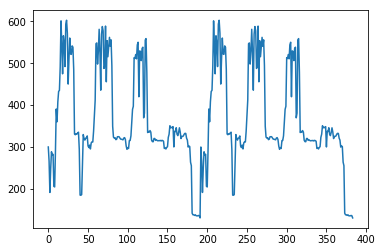

In [8]:
readings_df['read_value'].plot()

In [13]:
pub_hols_list_of_dfs = []
pub_hols_url_list = ['https://data.gov.au/data/dataset/b1bc6077-dadd-4f61-9f8c-002ab2cdff10/resource/bda4d4f2-7fde-4bfc-8a23-a6eefc8cef80/download/australian_public_holidays_2019.csv',
                     'https://data.gov.au/data/dataset/b1bc6077-dadd-4f61-9f8c-002ab2cdff10/resource/c4163dc4-4f5a-4cae-b787-43ef0fcf8d8b/download/australian_public_holidays_2020.csv']
for url in pub_hols_url_list:
    pub_hols_list_of_dfs.append(pd.read_csv(url,parse_dates = ['Date']))
pub_hols_df = pd.concat(pub_hols_list_of_dfs,sort=False,join='inner').drop(columns=['Information','More Information'])
pub_hols_df['Date'] = pub_hols_df['Date'].apply(lambda x : x.date())

state = 'vic'
pub_hols_single_state = pub_hols_df[pub_hols_df['Jurisdiction']==state]
pub_hols_single_state

,Date,Holiday Name,Jurisdiction
73,2019-01-01,New Year's Day,vic
74,2019-01-28,Australia Day,vic
75,2019-03-11,Labour Day,vic
76,2019-04-19,Good Friday,vic
77,2019-04-20,Saturday before Easter Sunday,vic
...,...,...,...
84,2020-09-25,Friday before AFL Grand Final,vic
85,2020-11-03,Melbourne Cup,vic
86,2020-12-25,Christmas Day,vic
87,2020-12-26,Boxing Day,vic


In [36]:
merged_df = hourly_df.merge(pub_hols_single_state, how='left',left_on='Date', right_on='Date')
merged_df['workday'] = (merged_df['Holiday Name'].isna()) & (merged_df['weekday'] < 5)
merged_df

,t_start,t_end,read_value,uom,meter_serial_number,quality_method,event_code,event_desc,read_start,read_end,Date,hour,weekday,Holiday Name,Jurisdiction,workday
0,2019-03-10 00:00:00,2019-03-10 01:00:00,566.10,KWH,01002,A,,,NaN,NaN,2019-03-10,0,6,NaN,NaN,False
1,2019-03-10 01:00:00,2019-03-10 02:00:00,439.35,KWH,01002,A,,,NaN,NaN,2019-03-10,1,6,NaN,NaN,False
2,2019-03-10 02:00:00,2019-03-10 03:00:00,569.40,KWH,01002,A,,,NaN,NaN,2019-03-10,2,6,NaN,NaN,False
3,2019-03-10 03:00:00,2019-03-10 04:00:00,488.55,KWH,01002,A,,,NaN,NaN,2019-03-10,3,6,NaN,NaN,False
4,2019-03-10 04:00:00,2019-03-10 05:00:00,494.25,KWH,01002,A,,,NaN,NaN,2019-03-10,4,6,NaN,NaN,False
5,2019-03-10 05:00:00,2019-03-10 06:00:00,750.75,KWH,01002,A,,,NaN,NaN,2019-03-10,5,6,NaN,NaN,False
6,2019-03-10 06:00:00,2019-03-10 07:00:00,840.30,KWH,01002,A,,,NaN,NaN,2019-03-10,6,6,NaN,NaN,False
7,2019-03-10 07:00:00,2019-03-10 08:00:00,926.85,KWH,01002,A,,,NaN,NaN,2019-03-10,7,6,NaN,NaN,False
8,2019-03-10 08:00:00,2019-03-10 09:00:00,1142.85,KWH,01002,A,,,NaN,NaN,2019-03-10,8,6,NaN,NaN,False
9,2019-03-10 09:00:00,2019-03-10 10:00:00,1039.95,KWH,01002,A,,,NaN,NaN,2019-03-10,9,6,NaN,NaN,False


In [58]:
merged_df.pivot_table(index='hour',columns=['workday'],values='read_value',margins=True,margins_name='Total')

workday,False,True,Total
hour,,,
0,607.200000,634.6500,620.925000
1,520.350000,595.9500,558.150000
2,584.625000,594.6000,589.612500
3,555.300000,627.2250,591.262500
4,572.175000,682.9500,627.562500
5,769.800000,739.8000,754.800000
6,967.500000,859.4250,913.462500
7,976.575000,834.3000,905.437500
8,1124.325000,888.0000,1006.162500
